In [20]:
from typing import List, Union
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.5)

import matplotlib.pyplot as plt
%matplotlib inline

## Introduction

The Kaplan-Meier method is one way to estimate the survival curve $S(t)$ of a population based on observed event and censoring times. The method is extremely simple -- below we will implement the method using numpy in two lines of code. The basic idea is that the survival curve itself is at each time point $t$ a free parameter to be estimated subject to the condition that
    $$S(t+\Delta t) = S(t)P(\text{survive to }t + \Delta t|\text{survive to }t)$$

One question that inevitably comes up when computing Kaplan-Meier curves is whether two curves are significantly different. The log-rank test is one commonly-applied techniques to address this question. The log-rank test is also quite easy to understand and here will we see a visually demonstration of the statistical test.

In [81]:
def sample_survival_times(
    n_patients: int,
    survival_function: np.array) -> np.array:
    
    # sample survival times
    survival_samples = np.random.rand(n_patients)
    observation_time = len(survival_function)
    survival_times = observation_time - np.searchsorted(survival_function[::-1], survival_samples)    

    return survival_times
    
def generate_survival_data(
    n_patients: int,
    survival_function: np.array, 
    censor_rate: float) -> pd.DataFrame:

    # require a non-increasing survival function that begins at 1
    assert survival_function[0] == 1
    assert np.all(survival_function[:-1] >= survival_function[1:])

    # sample survival times
    survival_times = sample_survival_times(n_patients, survival_function)

    # apply censoring --
    # censoring is basically a competing survival process, in this case
    # with an assumed constant rate
    time = np.linspace(0, len(survival_function), len(survival_function) + 1)
    censoring_survival = np.exp(- censor_rate * time)
    censoring_times = sample_survival_times(n_patients, censoring_survival)
    
    patients = list(range(n_patients))
    time_to_event = np.minimum(survival_times, censoring_times)
    censoring_flag = np.argmin(np.vstack((survival_times, censoring_times)), axis=0)
    
    return pd.DataFrame.from_dict({
        'patient':patients,
        'event_time':time_to_event,
        'is_censored':censoring_flag
    })    

## Problem Setup

In order to demonstrate the estimation of survival curves by the KM approach, let's start by simulating patient data with a known survival curve. Since KM is a non-parametric method, let's at least use a survival curve that's complex enough to not be simply modelled by an exponential. An interesting example is a survival curve in which the initial hazard rate is quite large, but over time the hazard decreases. This example could be very interesting for a medication in which most patients experience severe side effects early on, but over time the risk for severe events decreases.

In [22]:
#| include: true
def sigmoid(x):
    return 1./(1 + np.exp(-x))

def generate_two_phase_hazard(
    rate_1: float,
    rate_2: float,
    transition_time: int, 
    transition_dur: int,
    observation_time: int):
    
    # divide by 2 between the window is symmetric about the transition time
    transition_dur = transition_dur / 2 
    
    time = np.linspace(0, observation_time, observation_time + 1)
    hazard = \
        rate_1 * sigmoid(-(time - transition_time) / transition_dur) + \
        rate_2 * sigmoid( (time - transition_time) / transition_dur) 

    return hazard

def compute_survival_from_hazard_rate(hazard_rate):
    hazard_rate = np.hstack((np.array(0), hazard_rate[:-1]))
    return np.exp(-hazard_rate.cumsum())

rate_1 = 1./60     # 1 event per 60 days
rate_2 = 1./180    # 1 event per year
observation_time = 365 * 5
transition_time = 90
transition_dur = 45
hazard_rate = generate_two_phase_hazard(rate_1, rate_2, transition_time, transition_dur, observation_time)
survival_function = compute_survival_from_hazard_rate(hazard_rate)
assert np.isclose(survival_function[0], 1)
survival_function = survival_function / survival_function[0]

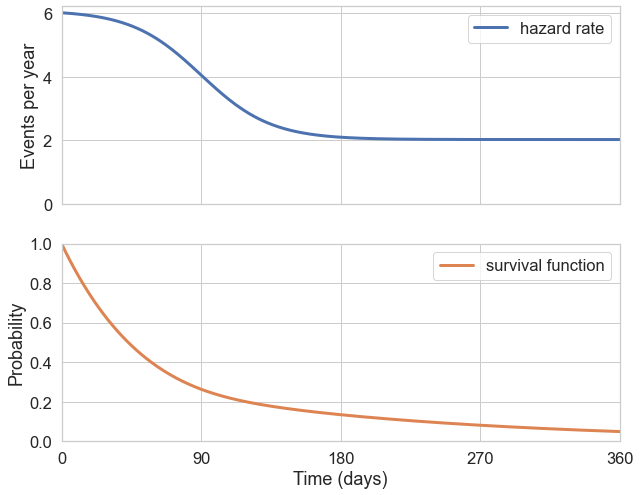

In [23]:
#| label: fig-survival
#| fig-cap: "Test"
#| include: true
#| echo: false
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))
axes[0].plot(365 * hazard_rate, linewidth=3, label='hazard rate',  c=sns.color_palette()[0])
tmax = 360
axes[0].set_xlim([0, tmax])
axes[0].set_xlim([0, tmax])
axes[0].set_ylim(ymin=0)
axes[0].set_xticks([0, 90, 180, 270, 360])
axes[0].set_ylabel('Events per year')
axes[0].legend()

axes[1].plot(survival_function, linewidth=3, label='survival function', c=sns.color_palette()[1])
axes[1].set_xlim([0, tmax])
axes[1].set_xlim([0, tmax])
axes[1].set_ylim([0, 1])
axes[1].set_xticks([0, 90, 180, 270, 360])
axes[1].set_ylabel('Probability')
axes[1].legend()
_ = axes[1].set_xlabel('Time (days)')

Let's now simulate 100 patients subject to the above survival curve and see that we can use the Kaplan-Meier approach to estimate the true curve.

In [83]:
#| include: true

def sample_survival_times(
    n_patients: int,
    survival_function: np.array) -> np.array:
    
    # sample survival times
    survival_samples = np.random.rand(n_patients)
    observation_time = len(survival_function)
    survival_times = observation_time - np.searchsorted(survival_function[::-1], survival_samples)    

    return survival_times
    
def generate_survival_data(
    n_patients: int,
    survival_function: np.array, 
    censor_rate: float) -> pd.DataFrame:

    # require a non-increasing survival function that begins at 1
    assert survival_function[0] == 1
    assert np.all(survival_function[:-1] >= survival_function[1:])

    # sample survival times
    survival_times = sample_survival_times(n_patients, survival_function)

    # apply censoring --
    # censoring is basically a competing survival process, in this case
    # with an assumed constant rate
    time = np.linspace(0, len(survival_function), len(survival_function) + 1)
    censoring_survival = np.exp(- censor_rate * time)
    censoring_times = sample_survival_times(n_patients, censoring_survival)
    
    patients = list(range(n_patients))
    time_to_event = np.minimum(survival_times, censoring_times)
    censoring_flag = np.argmin(np.vstack((survival_times, censoring_times)), axis=0)
    
    return pd.DataFrame.from_dict({
        'patient':patients,
        'event_time':time_to_event,
        'is_censored':censoring_flag
    })    

n_patients = 100
censor_rate = 1./180
cohort_1_events = generate_survival_data(n_patients, survival_function, censor_rate)
cohort_1_events

,patient,event_time,is_censored
0,0,62,0
1,1,18,0
2,2,34,0
3,3,10,0
4,4,34,0
...,...,...,...
95,95,93,0
96,96,55,1
97,97,112,1
98,98,60,1


## Kaplan-Meier Curve

In order to calculate the KM curve, we first need to aggregate the patient data by event time as follows:

In [26]:
#| include: true

def aggregate_events(patient_level_events: pd.DataFrame) -> pd.DataFrame:

    n_patients = len(patient_level_events)
    agg_events = patient_level_events.groupby('event_time').agg(
        n_events = ('is_censored', lambda x: len(x) - sum(x)),
        n_censored = ('is_censored', lambda x: sum(x)))
    agg_events.loc[0] = [0, 0]
    agg_events = agg_events.sort_values('event_time')
    agg_events.loc[:, 'at_risk'] = n_patients - \
        (agg_events['n_events'] + agg_events['n_censored']).shift(1).fillna(0).cumsum().astype(int)

    return agg_events

cohort_1_events_agg = aggregate_events(cohort_1_events)
cohort_1_events_agg


,n_events,n_censored,at_risk
event_time,,,
0,0,0,100
1,2,2,100
2,2,0,96
3,3,1,94
4,1,2,90
...,...,...,...
352,1,0,5
382,1,0,4
384,0,1,3


Now the calculation of the KM curve is exceedingly simple.

In [87]:
#| include: true
#| code-fold: true
def estimate_kaplan_meier_survival(
    n_events: np.array, 
    at_risk: np.array) -> np.array:
    
    km_estimate = 1 - n_events / at_risk
    km_estimate = km_estimate.cumprod()
    return km_estimate


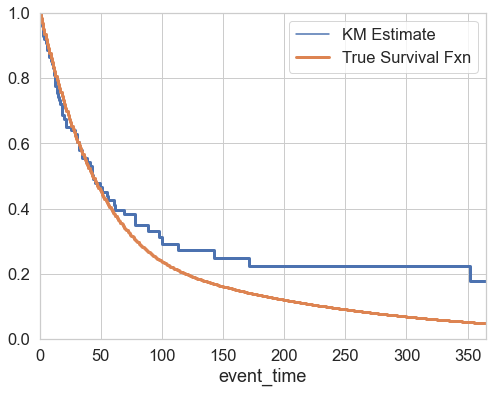

In [88]:
#| label: fig-survival-est
#| fig-cap: "Test"
#| include: true
#| echo: false
    
cohort_1_events_agg.loc[:, 'KM Estimate'] = estimate_kaplan_meier_survival(
    cohort_1_events_agg['n_events'], cohort_1_events_agg['at_risk'])
cohort_1_events_agg.loc[:, 'survival_input'] = survival_function[cohort_1_events_agg.index]

fig = plt.figure(figsize=(8,6))
ax = sns.lineplot(
    data=cohort_1_events_agg[['KM Estimate']], 
    linewidth=3,
    dashes=False,
    drawstyle='steps-post'
)
ax.plot(survival_function, drawstyle='steps-post', linewidth=3, label='True Survival Fxn')
ax.legend()
ax.set_ylim([0, 1])
_ = ax.set_xlim([0, 365])


## Log-Rank Test

In [30]:
def random_split_cohort(cohort_1_events, split_col='patient'):
    
    split_cohort_1 = cohort_1_events.sample(frac=0.5, replace=False)
    split_cohort_2 = cohort_1_events[~cohort_1_events[split_col].isin(split_cohort_1[split_col])]

    split_agg_1 = aggregate_events(split_cohort_1)
    split_agg_2 = aggregate_events(split_cohort_2)

    split_agg_1.loc[:, 'KM Estimate (1)'] = estimate_kaplan_meier_survival(
        split_agg_1['n_events'], split_agg_1['at_risk'])
    split_agg_2.loc[:, 'KM Estimate (2)'] = estimate_kaplan_meier_survival(
        split_agg_2['n_events'], split_agg_2['at_risk'])
    
    return split_agg_1, split_agg_2

split_agg_1, split_agg_2 = random_split_cohort(cohort_1_events)

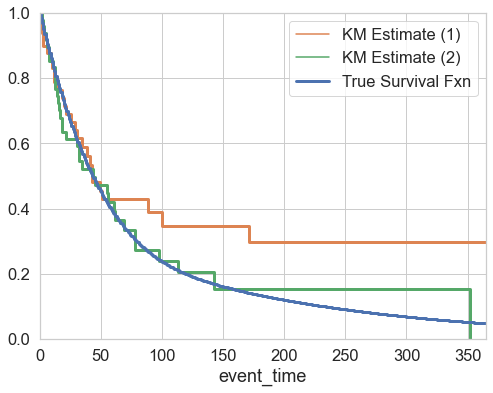

In [85]:
#| label: fig-survival-split
#| fig-cap: "Test"
#| include: true
#| echo: false

fig = plt.figure(figsize=(8,6))
ax = sns.lineplot(
    data=split_agg_1[['KM Estimate (1)']], 
    linewidth=3,
    dashes=False,
    drawstyle='steps-post',
    palette=sns.color_palette()[1:2]
)
ax = sns.lineplot(
    data=split_agg_2[['KM Estimate (2)']], 
    linewidth=3,
    dashes=False,
    drawstyle='steps-post',
    palette=sns.color_palette()[2:3]
)
ax.plot(
    survival_function, 
    drawstyle='steps-post', 
    linewidth=3, 
    label='True Survival Fxn',
    color=sns.color_palette()[0]
)
ax.legend()
ax.set_ylim([0, 1])
_ = ax.set_xlim([0, 365])


(0.0, 365.0)

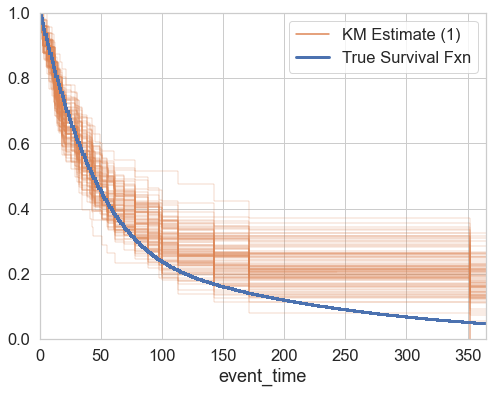

In [38]:
#| label: fig-survival-sampled
#| fig-cap: "Test"
#| include: true
fig = plt.figure(figsize=(8,6))
lr = []
for _ in range(100):
    split_agg_1, split_agg_2 = random_split_cohort(cohort_1_events)
    lr.append(compute_log_rank(split_agg_1))
    
    ax = sns.lineplot(
        data=split_agg_1[['KM Estimate (1)']], 
        linewidth=0.3,
        dashes=False,
        drawstyle='steps-post',
        palette=sns.color_palette()[1:2],
        ax=fig.gca()
    )
    ax.plot(
        survival_function, 
        drawstyle='steps-post', 
        linewidth=3, 
        label='True Survival Fxn',
        color=sns.color_palette()[0]
    )
# ax.legend()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_ylim([0, 1])
ax.set_xlim([0, 365])


In [70]:
def compute_log_rank(split_agg_1, split_agg_2):
    
    df = split_agg_2.merge(
        split_agg_1,
        how='outer', 
        left_index=True, 
        right_index=True, 
        suffixes=['_1', '_2'])
    
    df.loc[:, 'at_risk_1'] = df['at_risk_1'].fillna(method='ffill')
    df.loc[:, 'at_risk_2'] = df['at_risk_2'].fillna(method='ffill')

    df.loc[:, 'n_events_1'] = df['n_events_1'].fillna(0)
    df.loc[:, 'n_events_2'] = df['n_events_2'].fillna(0)
    
    df.loc[:, 'n_events_all'] = df['n_events_1'] + df['n_events_2']
    df.loc[:, 'at_risk_all'] = df['at_risk_1'] + df['at_risk_2']
    
    df.loc[:, 'n_events_expected'] = df['n_events_all'] * df['at_risk_1'] / df['at_risk_all']
    df.loc[:, 'ome'] = df['n_events_expected'] - df['n_events_1']
    log_rank = df['ome'].sum()**2 / df['n_events_expected'].sum()
    return log_rank


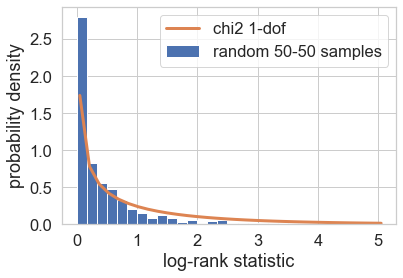

In [80]:
#| label: fig-logrank
#| fig-cap: "Test"
#| include: true

# lr = []
# for _ in range(1000):
#     split_agg_1, split_agg_2 = random_split_cohort(cohort_1_events)
#     lr.append(compute_log_rank(split_agg_1, split_agg_2))

from scipy.stats import chi2
_ = plt.hist(lr, bins=np.linspace(0, 5, 31), density=True, label='random 50-50 samples')
X = 0.05 + np.linspace(0, 5, 32)
y = [chi2.pdf(x, 1) for x in X]
plt.plot(X, y, linewidth=3, label='chi2 1-dof')
plt.xlabel('log-rank statistic')
plt.ylabel('probability density')
plt.legend()